## 因素分解及 Prophet 工具使用

#### 知识点

* 季节性趋势序列 
* 因素分解 
* Prophet 工具介绍 
* Prophet 工具快速入门 
* 趋势变化点 
* 乘法模型 

### 季节性趋势序列

我们经常使用 ARMA 和 ARIMA 对平稳和非平稳时间序列建模。实际上，我们所面对的序列都表现出一定程度的随机特性。当然，这种随机特性还没有到达不值得分析的地步。在时间序列的预测分析中，还有一种非常常见的序列，它们表现出十分显著的季节特性。

例如，下面给出了伦敦市历年（2000-2016）表面气温数据集。你会发现，气温的变化会随着时间的变化，呈现出明显的规律。

数据量： 6020


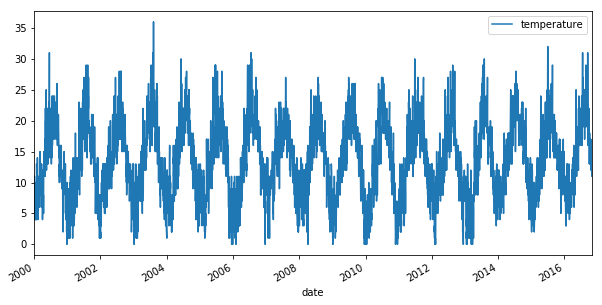

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

london = pd.read_csv(
    "http://labfile.oss.aliyuncs.com/courses/1176/surface-temperature-observations.csv", index_col=0)
london.index = pd.to_datetime(london.index)  # 转换时间索引
print("数据量：", len(london))
london.plot(figsize=(10, 5))  # 绘图

### 因素分解介绍

那么，对于这样的序列数据，我们往往会使用一种叫因素分解方法来分析。因素分解法最早由英国统计学家 W.M.Persons 在 1919 年提出。简单来讲，我们认为时间序列的波动虽然各式各样，但都可以总结为受以下四类因素影响：

- 长期趋势 Trend：$T_t$ 因素的影响会导致序列星现出明显的长期趋势（递增、递减等）。
- 循环波动 Circle：$C_t$ 因素会导致序列呈现出从低到高再由高至低的反复循环波动。
- 季节性变化 Season：$S_t$ 因素会导致序列星现出和季节变化相关的稳定的周期波动。
- 随机波动 lmmediate $I_t$ ：除了长期趋势、循环波动和季节性变化之外，序列还会受到各种其他因素的综合影响，而这些影响导致序列星现出一定的随机波动。

于是，在进行时序分析时，我们假定序列会受到这四个因素中的全部或部分的影响，呈现出不同的波动特征。从而衍生出两种模型：加法模型和乘法模型。

加法模型，顾名思义就是将上述四类因素相加组合在一起：

$$
x_t = T_t + C_t + S_t + I_t
$$

乘法模型，同样就是将上述四类因素相乘组合在一起：

$$
x_t = T_t * C_t * S_t * I_t
$$

因素分解思想主要有以下两个优点：

1. 克服其它因素干扰，单纯测度出某一个确定性因素（季节、趋势等）对序列的影响。
2. 根据序列出现的确定性特征，推断出各种确定性因素彼此之间的相互作用关系以及它们对序列的综合影响。

### Prophet 工具介绍

Prophet 是 Facebook 于 2017 年开源的时间序列分析工具，其提供支持 R 和 Python 语言的接口。Prophet 开发的理论基础依赖于因素分解法中的加法模型，故其非常适合于季节性时间序列数据分析。与此同时，Prophet 内建了缺失值和异常值处理机制，能从一定程度上减少序列预处理的负担。

Prophet 原本是 Facebook 核心数据分析团队的内部工具，开源之后的确有助于更多人对季节性时间序列完成确定性分析。加法模型虽然听起来很简单，但其推导和实现非常复杂，Prophet 从一定程度上降低了使用和分析门槛。

如果你想在本地安装并使用 Prophet，非常推荐使用 conda 避免编译错误。现在，你需要在环境中依次执行下面的单元格来安装 fbprophet 库。时间稍长，耐心等待。

### 加法模型

接下来，我们将使用上面提供的伦敦市表面气温数据集，来学习 Prophet 工具的使用。

Prophet 规定传入的数据必须遵循一定的数据结构，其只能包含两列数据，分别是：时间 `ds` 和数值 `y`。于是，我们现对 `london` 数据集进行处理。

In [2]:
"""此单元格只能执行一次，重复执行需重启 kernel
"""
london = london.reset_index()  # 重置索引
london.columns = ['ds', 'y']
london.head()

,ds,y
0,2000-01-02,8
1,2000-01-03,11
2,2000-01-04,6
3,2000-01-05,11
4,2000-01-06,11


上方的单元格只能执行一次，原因是 `reset_index()` 重置索引的操作重复运行会有累计效应而报错。

接下来，我们需要检查 `ds` 的格式，根据 Prophet 规定，推荐格式为 `YYYY-MM-DD` 或 `YYYY-MM-DD HH:MM:SS`。同时，`y` 列必须为数字。由于 `london` 符合要求，就无需再做改变。

Prophet 提供了与 scikit-learn 相似的 API 结构。当我们使用其创建加法模型示例后，调用 `fit` 和 `predict` 方法即可完成训练和预测。

In [3]:
from fbprophet import Prophet
import warnings

warnings.filterwarnings('ignore')  # 忽略警告
m = Prophet()  # 创建加法模型
m.fit(london)  # 训练

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


接下来，我们创建一个预测序列，这里可以直接使用 `make_future_dataframe` 方法，也可以自己通过 Pandas 创建相应格式的 DataFrame。`make_future_dataframe` 方法支持 `pd.date_range` 方法支持的全部 `freq`。原数据频率为天 `freq='D'`，所以这里创建接下来 365 天的待预测序列时间索引。

In [4]:
future = m.make_future_dataframe(periods=365, freq='D')  # 生成预测序列
future.tail()  # 显示序列最后 5 个数据

,ds
6380,2017-10-27
6381,2017-10-28
6382,2017-10-29
6383,2017-10-30
6384,2017-10-31


预测当然就是调用 `predict` 方法。注意，`predict` 会返回一个 `19` 列的 DataFrame。该 DataFrame 包含了季节性指标数据以及相应的置信区间。这里，我们只取出 `'yhat', 'yhat_lower', 'yhat_upper'` 3 列数据，其代表预测值 $\hat y$，以及对应的置信区间。

In [5]:
forecast = m.predict(future)  # 预测
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()  # 仅保留预测值和相应的置信区间

,ds,yhat,yhat_lower,yhat_upper
0,2000-01-02,6.855539,2.908542,10.902475
1,2000-01-03,6.890269,3.257404,11.147236
2,2000-01-04,6.848670,2.831210,10.872314
3,2000-01-05,6.958803,2.812320,11.083277
4,2000-01-06,6.992342,2.978908,10.862008


最后，我们可以将预测数据绘图。

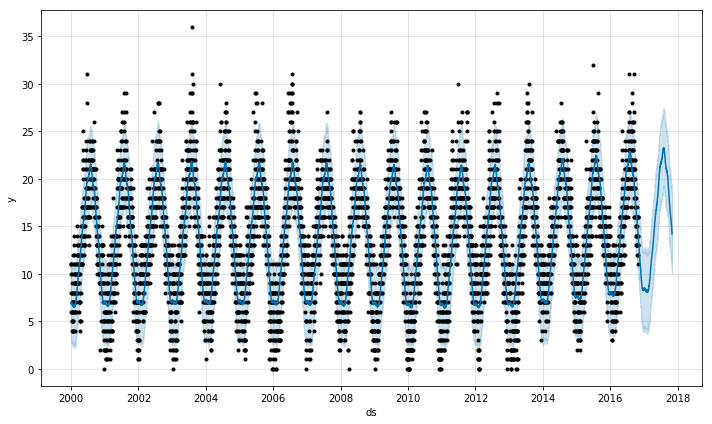

In [6]:
fig = m.plot(forecast)  # 绘图

如上所示，黑色点代表真实值，蓝色线代表预测值，蓝色区间代表置信区间。由于 `make_future_dataframe` 在生成预测序列时也会包含原序列的时间，所以在预测时，实际上传入的是原序列 + 预测序列。故上图你可以看到置信区间一直从 2000 年延伸到 2018 年。

实际上，我们也可以不使用 Prophet 提供的相应方法，自行生成预测序列以及绘图。这样可以保证在原序列不变的前提下，绘制出预测值和置信区间。

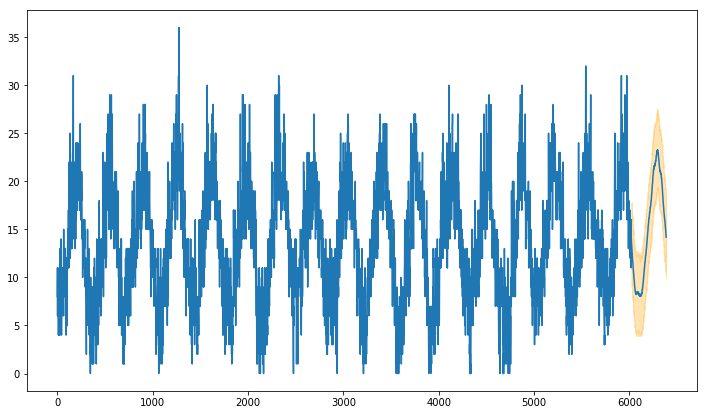

In [7]:
"""此单元格只能执行一次，重复执行需重启 kernel
"""

future_ = future[len(london):]  # 得到不包含原序列的预测序列时间索引
forecast_ = m.predict(
    future_)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # 预测

london.columns = ['ds', 'yhat']  # 修改原数据列名
forecast_ = pd.concat([london, forecast_], sort=False)  # 合并原数据和预测数据 DataFrame
forecast_ = forecast_.reset_index(drop=True)  # 将合并后 DataFrame 重置索引编号

fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(forecast_.index, forecast_['yhat'])  # 绘制原数据图
axes.fill_between(forecast_.index, forecast_['yhat_lower'],
                  forecast_['yhat_upper'], color='orange', alpha=.3)  # 绘制预测序列和置信区间

可以看到，上面就保证了原数据图像不变的情况下，直接在最后添加上了预测值和对于的置信区间。由图可见，预测数据的变化趋势和原数据相似，延续了序列季节性变化特性。

### 趋势变化点

上面的小节中，我们使用真实数据集对 Prophet 快速建立加法模型进行了学习。实际上，Prophet 还提供了其他一些有用的方法帮助我们在时序预测时使用，其中一个就是绘制趋势变化点。

趋势变化点，也就是时间序列突然引起的变化，例如从某时刻开始序列整体趋势突然由下降转为增长。标注趋势变化点是观察序列周期和变化趋势非常好的手段。Prophet 能自动检测并将这些变化点标记出来，我们需要借助于 `add_changepoints_to_plot` 方法。

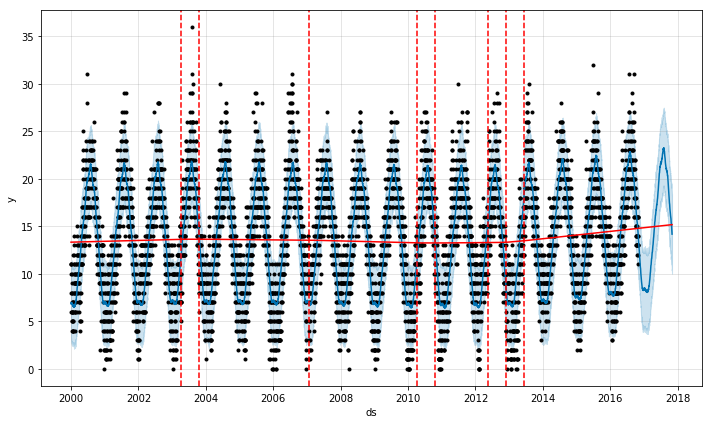

In [8]:
from fbprophet.plot import add_changepoints_to_plot

fig_base = m.plot(forecast)  # 绘制预测结果
fig = add_changepoints_to_plot(fig_base.gca(), m, forecast)  # 将变化点添加到预测结果图

请注意，这里的变化点并不是对序列值由增至减或由减至增变化时的标记，而是序列变化的整体趋势。如上图所示，横向红线标记了序列的整体变化趋势，此趋势线的变化点即被标记出趋势变化点。

### 乘法模型

上面伦敦气温变化的示例中，加法模型能够很好地应对，因为预测时只需要将季节性趋势增加到序列中即可，类似于复制这种变化趋势。但在有一些序列中，加法模型就无法准确反映出变化的趋势，季节性趋势有可能成倍数增加状态。此时，就需要使用到乘法模型。

例如，下面提供了 1949 年至 1960 年期间某航空公司的乘客数量变化序列。

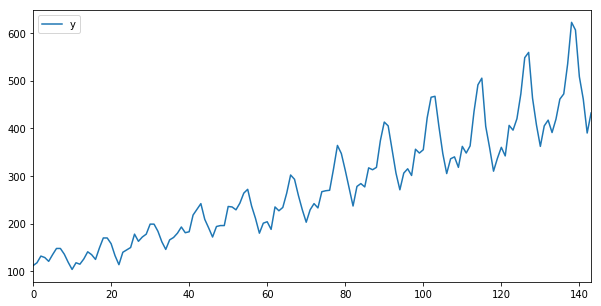

In [9]:
air = pd.read_csv(
    'http://labfile.oss.aliyuncs.com/courses/1176/example_air_passengers.csv')
air.plot(figsize=(10, 5))  # 绘图

可以明显看出，乘客数量反应到季节性上，呈现出逐年扩大的趋势。此时，如果我们应用加法模型预测。

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


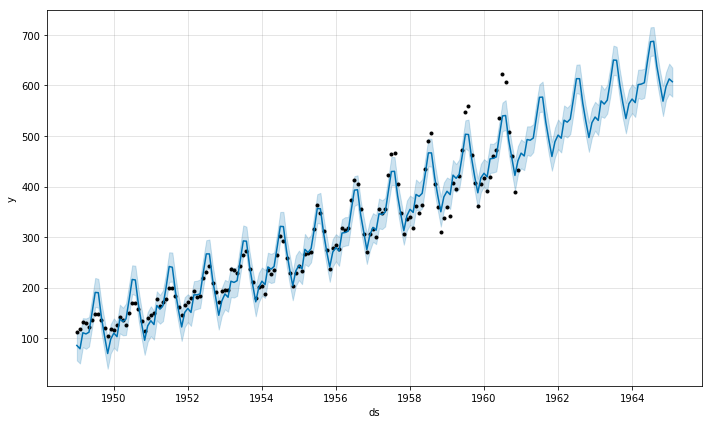

In [10]:
m_additive = Prophet()  # 加法模型
m_additive.fit(air)  # 训练
future = m_additive.make_future_dataframe(50, freq='MS')  # 生成预测时间序列
forecast = m_additive.predict(future)  # 预测
fig = m_additive.plot(forecast)  # 绘图

如上图所示，加法模型在季节性周期变化上是固定的。虽然整体呈现增长趋势，但后续周期中的序列值预测明显无法准确反应原数据的变化。此时，我们就引入乘法模型。

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


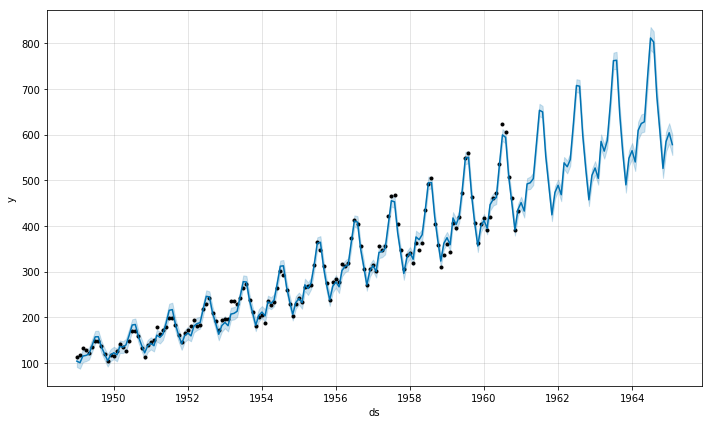

In [11]:
m_multiplicative = Prophet(seasonality_mode='multiplicative')  # 乘法模型
m_multiplicative.fit(air)  # 训练
future = m_multiplicative.make_future_dataframe(50, freq='MS')  # 生成预测时间序列
forecast = m_multiplicative.predict(future)  # 预测
fig = m_multiplicative.plot(forecast)  # 绘图

如上图所示，乘法模型就能反映出乘客数量随周期倍增的特性，相比于加法模型，预测结果一定会更加准确。

### 实验总结

本次实验中，我们接触到了呈现出季节性特征的序列数据，并学会使用 Prophet 工具建立加法和乘法模型。简单来讲，如果序列每个季节周期内的变化不明显，那么就可以使用加法模型。反之，如果序列随着时间增加，每个季节周期内的趋势增加或减小，则偏向于使用乘法模型。